# Описательные статистики в Julia.

Посмотрим теперь на некоторые "фишки" Julia в плане предобработки и предварительной разведки данных.

In [2]:
using Distributions

In [3]:
# сгенерируем данные 
d = Distributions.Normal(0, 3)
data = rand(d, 1000);

In [4]:
# найдем некоторые базовые величины
# среднее значение выборки
mean(data)

-0.06620170807274617

In [8]:
# стандартное отклонение выборки
std(data)

3.083715216537482

In [11]:
# NB : значение подправленное по умолчанию, т.е. делится на n - 1 = length(data) - 1 
# дает несмещенную оценку дисперсии
sqrt(sum((data .- mean(data)) .^ 2)/(length(data) - 1))

3.083715216537482

In [13]:
# неподправленное значение
std(data, corrected = false)

3.0821729732719585

In [16]:
# первая квартиль
quantile(data, 1/4)

-2.2089273999676733

In [17]:
# третья квартиль
quantile(data, 3/4)

2.124341314274265

In [19]:
# мода - самое часто встречаемое значение в массиве
mode(data)

0.7957277772300673

In [20]:
# медиана
median(data)

-0.08457979651488791

In [28]:
# максимальное значение - обратите внимание, maximum, а не max
maximum(data)

7.89002853989554

In [29]:
minimum(data)

-9.933790450807082

In [52]:
# пример - функция подсчёта z-value
# не запускать на массиве с нулевой дисперсией!
function z_value(x :: AbstractArray)
    xMean = mean(x)
    xStd = std(x)
    return (x .- xMean) ./ xStd
end

zVals = z_value(data);

In [34]:
# построим графики boxplot и гистограммы
using Gadfly

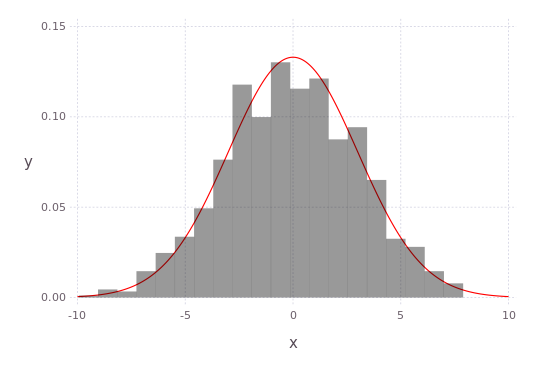

In [49]:
# построение гистограммы с наложенным графиком плотности распределения, из которого взята выборка
plot(layer(x = data, Geom.histogram(bincount = 20, density = true)), Theme(default_color=Colors.RGBA(0,0,0, 0.4)),
    layer(x -> pdf(d,x), -10, 10, Theme(default_color = "red")))

Для того, чтобы сделать гистограмму прозрачной, нужно немного помудрить. Для этого в качестве параметра в Theme передается объект Color, первые три координаты которого задают цвет, четвертая отвечает за прозрачность.

Второй слой просто рисует функцию плотности нормального распределения, аргументом передается анонимная функция x -> pdf(d,x), т.е. плотность распределения d.

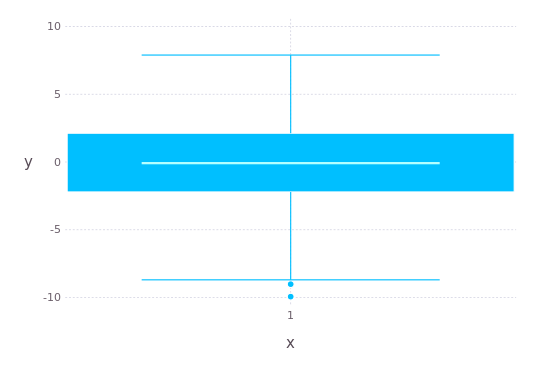

In [53]:
# построение boxplot-a
plot(x = [1], y = data, Geom.boxplot)

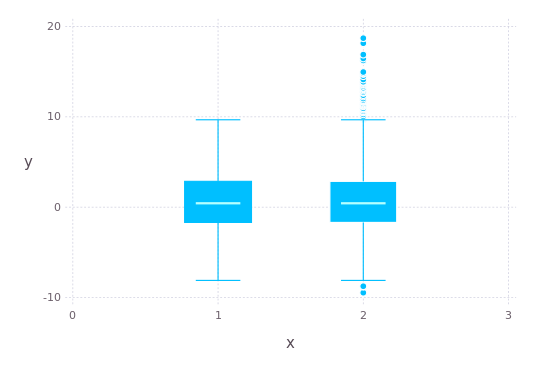

In [84]:
# при большом количестве выбросов можно "подавить" вывод выбросов.
# ранее Gadfly ломался, когда выбросов было очень много, сейчас это пофиксили
dataCorrupted = rand(d, 1000)
append!(dataCorrupted, rand(d, 100) .+ 10);
plot(layer(x = [1], y = dataCorrupted, Geom.boxplot(suppress_outliers = true)),
    layer(x = [2], y = dataCorrupted, Geom.boxplot(suppress_outliers = false)),
    Coord.cartesian(xmin = 0, xmax = 3),
    Theme(boxplot_spacing = 4inch)
    )

Сравним медиану, моду и среднее значение для симметричных и несимметричных данных. Сгенерируем данные, построим для них гистограмму, медиану, моду и среднее.

In [93]:
# симметричные данные
symData = rand(d, 1000)
symDataMedian = median(symData);
symDataMode = mode(symData);
symDataMean = mean(symData);

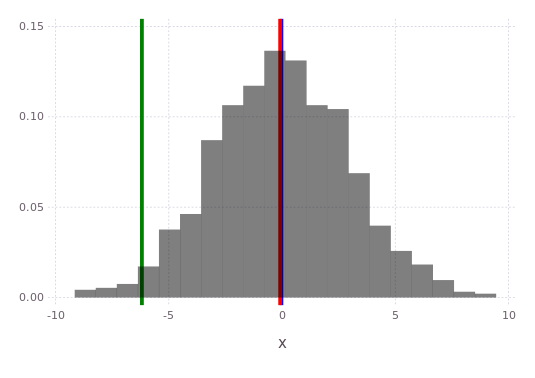

In [94]:
# построим графики
plot(
    layer(x = symData, Geom.histogram(bincount = 20, density = true), Theme(default_color=Colors.RGBA(0,0,0, 0.5))),
    layer(xintercept = [symDataMedian, symDataMode, symDataMean], 
        Geom.vline(color = ["red", "green", "blue"], size = 1mm))
)

Для массивов из непрерывного распределения мода определена не так хорошо и не может служить мерой центральной тенденции. Сгенерируем данные для дискретного распределения - биномиального.

In [96]:
bern = Distributions.Binomial(200, 0.7)

Distributions.Binomial{Float64}(n=200, p=0.7)

In [97]:
symData = rand(bern, 1000)
symDataMedian = median(symData);
symDataMode = mode(symData);
symDataMean = mean(symData);

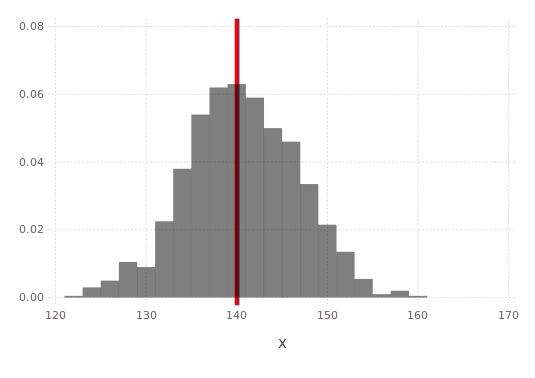

In [98]:
# построим графики - видно, что медиана, мода и среднее дают примерно одно и то же значение
plot(
    layer(x = symData, Geom.histogram(bincount = 20, density = true), Theme(default_color=Colors.RGBA(0,0,0, 0.5))),
    layer(xintercept = [symDataMedian, symDataMode, symDataMean], 
        Geom.vline(color = ["red", "green", "blue"], size = 1mm))
)

In [120]:
# несимметричные данные 
logn = Distributions.LogNormal(0, 1)

Distributions.LogNormal{Float64}(μ=0.0, σ=1.0)

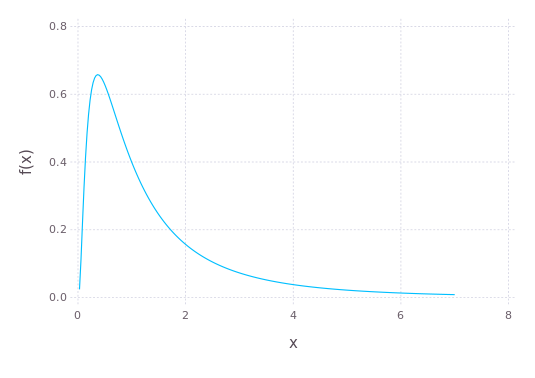

In [121]:
# несимметричные данные - тяжелый правый хвост
plot(x -> pdf(logn, x), 0, 7)

In [126]:
asymData = rand(logn, 300)
asymDataMedian = median(asymData);
#symDataMode = mode(symData);
asymDataMean = mean(asymData);

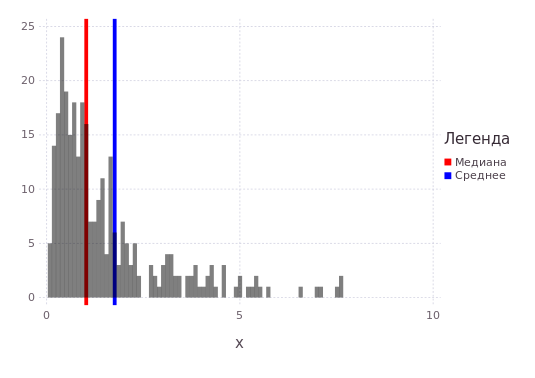

In [135]:
# тяжелые хвосты смещают среднее значение ближе к "хвосту"
plot(
    layer(x = asymData, Geom.histogram(), Theme(default_color=Colors.RGBA(0,0,0, 0.5))),
    layer(xintercept = [asymDataMedian, asymDataMean], 
        Geom.vline(color = ["red", "blue"], size = 1mm)),
    Coord.cartesian(xmin = 0, xmax = 10),
    Guide.manual_color_key("Легенда", ["Медиана","Среднее"], ["red", "blue"])
)

In [143]:
# выбросы также сильно влияют на среднее значение, смещая его влево. Медиана более устойчива к выбросам
data = rand(d, 1000)
dataCorrupted = copy(data)
dataCorrupted[1:50] .= 5 * rand(d, 50) .+ 20;
println("
        Медиана исходных данных : $(median(data)) \n
        Среднее исходных данных : $(mean(data)) \n
        Медиана испорченных данных : $(median(dataCorrupted)) \n
        Среднее испорченных данных : $(mean(dataCorrupted))"
        )


        Медиана исходных данных : 0.10311653060252804 

        Среднее исходных данных : 0.08318817256044521 

        Медиана испорченных данных : 0.18402578841744233 

        Среднее испорченных данных : 0.934207645923777
